In [1]:
import pandas as pd
import os,re,sarge
import numpy as np
from Bio import SeqIO
from natsort import natsorted
from pybedtools import BedTool
import matplotlib.pyplot as plt
import copy
%matplotlib inline
plt.style.use('ggplot')

In [7]:
ribo_taper_path  = '/data/shangzhong/RibosomeProfiling/Ribotaper'
pasa_path = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie'
picr_rna = pasa_path + '/03_pasa_stringtie_rna.fa'
orf = ribo_taper_path + '/ORFs_max'
orf_fil = ribo_taper_path + '/ORFs_max_filt'
thread = 16
ham_gff = pasa_path + '/03_pasa_stringtie.gff3'

In the RiboTaper result file ORFs_max_filt, the CDS start and stop position is represented using start position of P site, in the downstream analysis it would be easier to change it to the typical position as gff file.

In [5]:
def get_rna_coding_regions(rna_fa):
    '''this function gets the start and end positions of CDS in rna sequence in the form
    {rna:[cds_s,cds_e]}'''
    rna_dic = SeqIO.index(picr_rna,'fasta')
    cds_s_e_dic = {}
    for r in rna_dic:
        desp = rna_dic[r].description
        try:
            pos = re.search('(?<=CDS=).+?(?=$)',desp).group(0).split('-')
            pos = [int(p) for p in pos]
            cds_s_e_dic['-'.join(r.split('_'))] = pos
        except:
            pass
    return cds_s_e_dic

In [8]:
# change anno start and end position to gff format, 1 based
cds_s_e_dic = get_rna_coding_regions(picr_rna)
orf_fil_df = pd.read_csv(orf_fil,sep='\t',header=0)
orf_fil_df['annotated_start'] = orf_fil_df['transcript_id'].map(lambda x: 
                        cds_s_e_dic[x][0] if x in cds_s_e_dic else None)
orf_fil_df['annotated_stop'] = orf_fil_df['transcript_id'].map(lambda x: 
                        cds_s_e_dic[x][1] if x in cds_s_e_dic else None)
orf_fil_df['stop_pos'] += 2
orf_fil_df['start_pos'] -= 1
orf_fil_df['annotated_start'] -= 1

Ribotaper doesn't tell which isoforms the reads come from, it reports all the isofroms. eg:

...........AUG..|..|----intron--..|..|..|---intron---|..|..|..Stop

...........AUG..|..|------------intron---------------|..|..|..Stop
Both ORFs may be reported, but it does not necessarily mean that both actually exist.
So let's first check how many rnas in annotation doesn't have proteins, but their isoforms encode proteins.

In [9]:
def ncrna_gene_has_pr(gff):
    '''this function finds noncoding transcripts whose isoforms have proteins '''
    gff_df = pd.read_csv(ham_gff,sep='\t',header=None,comment='#')
    rna_df = gff_df[gff_df[2].values == 'mRNA']
    rna_df = rna_df.reset_index(drop=True)
    rna_df['rnaid'] = rna_df[8].map(lambda x:re.search('(?<=ID=).+?(?=;)',x).group(0))
    rna_df['rnaid'] = rna_df['rnaid'].map(lambda x: '-'.join(x.split('_')))
    rna_df['geneid']= rna_df[8].map(lambda x:re.search('(?<=gene_id=).+?(?=;)',x).group(0))
    rna_gid_dic = rna_df.set_index('rnaid')['geneid']

    cds_df = gff_df[gff_df[2].values=='CDS']
    cds_df = cds_df.reset_index(drop=True)
    cds_df['rnaid'] = cds_df[8].map(lambda x:re.search('(?<=Parent=).+?(?=;)',x).group(0))
    cds_df['rnaid'] = cds_df['rnaid'].map(lambda x: '-'.join(x.split('_')))
    cds_df['geneid']=cds_df[8].map(lambda x:re.search('(?<=gene_id=).+?(?=;)',x).group(0))
    coding_rnas = cds_df['rnaid'].unique().tolist()
    id_df = cds_df[['rnaid','geneid']].drop_duplicates()
    gid_crna_dic = {k:list(v) for k,v in id_df.groupby('geneid')['rnaid']}
    ncrna = list(set(rna_gid_dic.keys())-set(coding_rnas))
    ncrna_crna_dic = {}
    for rna in ncrna:
        try:
            gid = rna_gid_dic[rna]
            rnas = gid_crna_dic[gid]
            ncrna_crna_dic[rna] = [gid,rnas]
        except:
            pass
    return ncrna_crna_dic

ncrna_crna_dic = ncrna_gene_has_pr(ham_gff)
ncrna_crnas = ncrna_crna_dic.keys()

For some transcripts, ribotaper reports more than one protein. We split them and analyze them separtely. Each of them would have 3 categories when comparing with annotation: 
1. Annotation doesn't have protein.
2. start in the same frame, which means the end is the same.
3. start in the different frame, which means the end is not the same.

* Analyze transcripts with unique proteins first

In [11]:
# get duplicated rnas
dup_rnas = orf_fil_df[orf_fil_df['transcript_id'].duplicated()]['transcript_id'].unique().tolist()
uni_rnas = list(set(orf_fil_df['transcript_id'].unique().tolist())-set(dup_rnas))
uni_df = orf_fil_df[~orf_fil_df['transcript_id'].isin(dup_rnas)]
uni_df = uni_df.reset_index(drop=True)
dup_df = orf_fil_df[orf_fil_df['transcript_id'].isin(dup_rnas)]
dup_df = dup_df.reset_index(drop=True)

In [12]:
def get_rnas_in_diff_categories(uni_df):
    '''this function extract transcripts that have same proteins, have new proteins
    have different proteins in same frame, have different proteins in diff frame'''
    uni_same_rnas = uni_df.query('(start_pos==annotated_start) and (stop_pos==annotated_stop)')\
                    ['transcript_id'].unique().tolist()
    uni_no_rnas = uni_df[uni_df['annotated_start'].isnull()]['transcript_id'].unique().tolist()
    uni_diff_df = uni_df[~uni_df['transcript_id'].isin(uni_same_rnas+uni_no_rnas)]
    uni_diff_df = uni_diff_df.reset_index(drop=True)
    # change to integer
    uni_diff_df['annotated_start'] = uni_diff_df['annotated_start'].astype('int')
    uni_diff_df['annotated_stop'] = uni_diff_df['annotated_stop'].astype('int')
    # split same frame and different frame
    uni_diff_sf_rnas_df = uni_diff_df.query('(start_pos-annotated_start)%3==0')
    uni_diff_sf_rnas = uni_diff_sf_rnas_df['transcript_id'].unique().tolist()
    uni_diff_df_rnas_df = uni_diff_df.query('(start_pos-annotated_start)%3!=0')
    uni_diff_df_rnas = uni_diff_df_rnas_df['transcript_id'].unique().tolist()
    return uni_same_rnas, uni_no_rnas, uni_diff_sf_rnas, uni_diff_df_rnas, uni_diff_sf_rnas_df,\
        uni_diff_df_rnas_df
uni_rna_types = get_rnas_in_diff_categories(uni_df)
print 'In',len(uni_rnas),'transcripts with unique proteins, there are',len(uni_rna_types[0]),'have same '\
'proteins,',len(uni_rna_types[1]),'have new proteins,',len(uni_rna_types[2]),'have diff proteins '\
'in the same frame,',len(uni_rna_types[3]),'have diff proteins in diff frame'
uni_fil_no_rnas = list(set(uni_rna_types[1])-set(ncrna_crnas))
print 'After filterring out non coding rnas whose isoforms encode rnas, there are',\
len(uni_fil_no_rnas),'left to be further analyzed'
print 'there are',len(dup_rnas),'transcripts have duplicated proteins'

In 24709 transcripts with unique proteins, there are 13666 have same proteins, 1318 have new proteins, 8775 have diff proteins in the same frame, 950 have diff proteins in diff frame
After filterring out non coding rnas whose isoforms encode rnas, there are 1318 left to be further analyzed
there are 3991 transcripts have duplicated proteins


We are only interested in the proteins that are different from annotation.
1. For transcripts with new proteins, we keep the ones whose isoforms don't encode proteins.
2. For transcripts with diff proteins, we check how many of them are extended or shrinked.
First, let's see for different protiens in the same frame, how many proteins are extended or shriked compared to annotation

there are 495 extend rnas
there are 8280 shrink rans


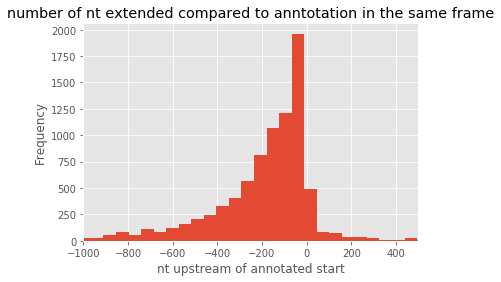

In [13]:
uni_diff_sf_rna_df = uni_rna_types[4]
uni_diff_sf_rna_df['dist']=uni_diff_sf_rna_df['annotated_start']-uni_diff_sf_rna_df['start_pos']
extend_rnas = uni_diff_sf_rna_df.query('dist>0')
shrink_rnas = uni_diff_sf_rna_df.query('dist<0')
print 'there are',len(extend_rnas),'extend rnas'
print 'there are',len(shrink_rnas),'shrink rans'
# plot
ax = uni_diff_sf_rna_df['dist'].plot(kind='hist',bins=500)
_ = ax.set_xlim([-1000,500])
_ = ax.set_title('number of nt extended compared to anntotation in the same frame')
_ = ax.set_xlabel('nt upstream of annotated start')

** From the above figure, we can see that most of the ribo protein differ from annotation in the same frame are shorter than the annotation. The possible reason is that the riboseq is CHO data, the annotation merged all tissues. which may reflect the real case that in CHO those proteins are shorter. 
Another possible reason is that transdecoder pipeline is more aggressive to include the upstream coding regions. **

For the proteins in different frames, check if they overlap with annotation or not.

In [19]:
uni_diff_ribo_anno_inter_df

,rnaid,ribo_s,ribo_e,rnaid_1,anno_s,anno_e,length
0,asmbl-10753,332,1433,asmbl-10753,1426,2740,7
1,asmbl-10788,1046,1220,asmbl-10788,373,1129,83
2,asmbl-10790,1132,1306,asmbl-10790,0,1215,83
3,asmbl-11084,237,969,asmbl-11084,841,2770,128
4,asmbl-11879,374,554,asmbl-11879,277,1630,180
5,asmbl-11971,174,1074,asmbl-11971,961,1720,113
6,asmbl-12151,334,436,asmbl-12151,0,1473,102
7,asmbl-12240,147,2211,asmbl-12240,2105,4937,106
8,asmbl-12321,387,492,asmbl-12321,35,512,105
9,asmbl-12929,34,433,asmbl-12929,2,2306,399


In [22]:
uni_diff_df_rna_df = uni_rna_types[5]
uni_diff_df_ribo_bed = BedTool.from_dataframe(uni_diff_df_rna_df[['transcript_id',
                                            'start_pos','stop_pos']])
uni_diff_df_anno_bed = BedTool.from_dataframe(uni_diff_df_rna_df[['transcript_id',
                                            'annotated_start','annotated_stop']])                                            
uni_diff_ribo_anno_inter_df = uni_diff_df_ribo_bed.intersect(uni_diff_df_anno_bed,wo=True)\
        .to_dataframe(names=['rnaid','ribo_s','ribo_e','rnaid_1','anno_s','anno_e','length'])
uni_diff_ribo_anno_inter_rnas = uni_diff_ribo_anno_inter_df.shape[0]
print 'there are',uni_diff_ribo_anno_inter_rnas,'ribo proteins in different frame and overlap with annotations'

there are 291 ribo proteins in different frame and overlap with annotations


In [24]:
# get proteins that are in different frame with annotation, and check if they are utr5 or utr3
uni_diff_ribo_anno_non_inter_df = uni_diff_df_ribo_bed.intersect(uni_diff_df_anno_bed,v=True)\
        .to_dataframe()
# get utr protein
uni_diff_ribo_anno_non_inter_df = uni_diff_df_rna_df[uni_diff_df_rna_df['transcript_id']\
                    .isin(uni_diff_ribo_anno_non_inter_df['chrom'].tolist())]
uni_diff_ribo_anno_non_inter_df = uni_diff_ribo_anno_non_inter_df.reset_index(drop=True)
# define if the utr is 5' or 3'
def utr_type(row):
    if row['start_pos']> row['annotated_start']:
        return '3'
    elif row['annotated_start'] > row['stop_pos']:
        return '5'
    else:
        assert False
uni_diff_ribo_anno_non_inter_df.loc[:,'utr_type']=uni_diff_ribo_anno_non_inter_df.apply(\
    lambda x:utr_type(x),axis=1)
utr_count = uni_diff_ribo_anno_non_inter_df['utr_type'].value_counts()
print 'In ribo proteins that in different frames with annotation, there are',utr_count['5'],'utr5 and',utr_count['3'],'utr3'

In ribo proteins that in different frames with annotation, there are 470 utr5 and 189 utr3


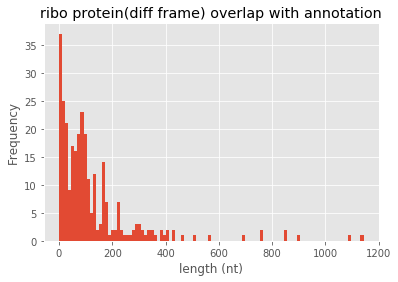

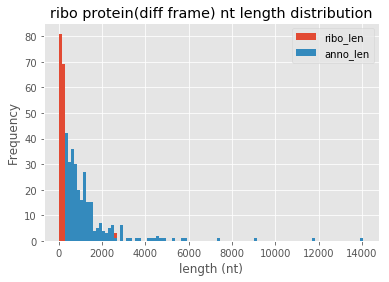

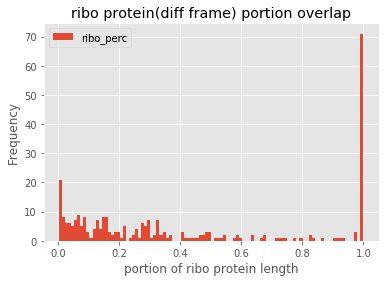

In [25]:
uni_diff_ribo_anno_inter_df['ribo_len']=uni_diff_ribo_anno_inter_df['ribo_e']-uni_diff_ribo_anno_inter_df['ribo_s']
uni_diff_ribo_anno_inter_df['anno_len']=uni_diff_ribo_anno_inter_df['anno_e']-uni_diff_ribo_anno_inter_df['anno_s']
uni_diff_ribo_anno_inter_df['ribo_perc']=uni_diff_ribo_anno_inter_df['length']/uni_diff_ribo_anno_inter_df['ribo_len']
ax = uni_diff_ribo_anno_inter_df['length'].plot(kind='hist',bins=100)
_ = ax.set_title('ribo protein(diff frame) overlap with annotation')
_ = ax.set_xlabel('length (nt)')
ax = uni_diff_ribo_anno_inter_df[['ribo_len','anno_len']].plot(kind='hist',bins=100)
_ = ax.set_title('ribo protein(diff frame) nt length distribution')
_ = ax.set_xlabel('length (nt)')
ax = uni_diff_ribo_anno_inter_df[['ribo_perc']].plot(kind='hist',bins=100)
_ = ax.set_title('ribo protein(diff frame) portion overlap')
_ = ax.set_xlabel('portion of ribo protein length')

** Analyze transcripts with duplicated proteins, it seems like there are many transcripts have multiple proteins, except the ones same with annotation, those proteins in different frames are much shorter than the annotation and are usually overlap with annotation. **

In [26]:
def dup_df2dic(dup_df):
    '''transfer duplicated proteins into dictionaries'''
    dup_norna_dic = {} # annotation doesn't have protein
    dup_dic = {}  # annotation has protein
    for index,row in dup_df.iterrows():
        rnaid = row['transcript_id']
        if np.isnan(row['annotated_start']):
            if rnaid in dup_norna_dic:
                dup_norna_dic[rnaid].append([row['start_pos'],row['stop_pos']])
            else:
                dup_norna_dic[rnaid] = [[row['start_pos'],row['stop_pos']]]
        else:
            if rnaid in dup_dic:
                dup_dic[rnaid].append([row['start_pos'],row['stop_pos']])
            else:
                dup_dic[rnaid]=[[int(row['annotated_start']),int(row['annotated_stop'])]
                               ,[row['start_pos'],row['stop_pos']]]
    # sort based on start position
    for k, v in dup_norna_dic.iteritems():
        dup_norna_dic[k] = sorted(v,key=lambda x:x[0])
    for k, v in dup_dic.iteritems():
        dup_dic[k] = [v[0]] + sorted(v[1:],key=lambda x:x[0])
    return dup_dic,dup_norna_dic

def check_overlap_nornas(dic):
    '''check how many rnas with duplicate novel proteins overlapped
    dic: {rnaid:[[s1,e1],[s2,e2]]}''' 
    dup_overlap_nornas = []
    for k,v in dic.iteritems():
        for i in range(len(v)-1):
            if range(max([v[i][0],v[i+1][0]]),min([v[i][1],v[i+1][1]])) != []:
                dup_overlap_nornas.append(k)
                break
    return dup_overlap_nornas

def check_overlap_rnas(dic):
    '''check how many rnas with duplicate proteins overlapped
    dic: {rnaid:[[anno_s,anno_e],[s1,e1],[s2,e2]]}''' 
    dup_overlap_rnas = []
    for k,v in dic.iteritems():
        for i in range(1,len(v)-1):
            if range(max([v[i][0],v[i+1][0]]),min([v[i][1],v[i+1][1]])) != []:
                dup_overlap_rnas.append(k)
                break
    return dup_overlap_rnas

In [30]:
dup_dic,dup_norna_dic = dup_df2dic(dup_df)
print 'In duplicated proteins, there are',len(dup_norna_dic),'rnas do not have',\
        'proteins in annotation but have proteins in riboseq'
dup_nornas = set(dup_norna_dic.keys())-set(ncrna_crnas)
print 'After filterring out non coding rnas whose isoforms encode rnas, there are',\
            len(dup_nornas),'left to be further analyzed'

In duplicated proteins, there are 311 rnas do not have proteins in annotation but have proteins in riboseq
After filterring out non coding rnas whose isoforms encode rnas, there are 310 left to be further analyzed


In [34]:
dup_overlap_nornas = check_overlap_nornas(dup_norna_dic)
print 'There are',len(dup_overlap_nornas),'rnas donot have proteins in annotation',\
            ' and have duplicated proteins in riboseq overlapped with each othter'
dup_overlap_rnas = check_overlap_rnas(dup_dic)
print 'There are',len(dup_overlap_rnas),'rnas have proteins in both annotaion and riboseq',\
        'and they overlapped with each other'

There are 54 rnas donot have proteins in annotation  and have duplicated proteins in riboseq overlapped with each othter
There are 733 rnas have proteins in both annotaion and riboseq and they overlapped with each other


* First analyze the rnas that have one ribo protein same with annotation

In [35]:
def get_stats4_dup_same_rnas(dup_same_rnas_dic):
    dup_utr5_rnas = []
    dup_utr3_rnas = []
    for k,v in dup_same_rnas_dic.iteritems():
        for i in v[1:]:
            if i[1] <= v[0][0]:
                i.append('utr5')
                dup_utr5_rnas.append(k)
            elif i[0]>=v[0][1]:
                i.append('utr3')
                dup_utr3_rnas.append(k)
            else:
                percent = (min(i[1],v[0][1])-max(i[0],v[0][0]))/float((i[1]-i[0]))
                i.append('overlap '+str(percent))
    dup_utr5_rnas = set(dup_utr5_rnas)
    dup_utr3_rnas = set(dup_utr3_rnas)
    dup_utr5_3_rnas = dup_utr5_rnas.intersection(dup_utr3_rnas)
    dup_same_rnas_overlap_rnas = set(dup_same_rnas_dic.keys())-dup_utr5_rnas-dup_utr3_rnas
    overlap_pct = {}
    for rna in dup_same_rnas_overlap_rnas:
        v = dup_same_rnas_dic[rna]
        for i in v[1:]:
            if v[0] != i[:2]:
                overlap_pct[rna]=float(i[2].split()[1])
    print 'there are',len(dup_utr5_3_rnas),'rnas have both 5 and 3 UTR and proteins'
    print 'there are',len(dup_utr5_rnas)-len(dup_utr5_3_rnas),'rnas that have ribo 5UTR and proteins'
    print 'there are',len(dup_utr3_rnas)-len(dup_utr5_3_rnas),'rnas that have ribo 3UTR and proteins'
    print 'there are',len(dup_same_rnas_overlap_rnas),'rnas that have prs overlap with annotation'
    return overlap_pct

In [36]:
# get rnas that have one ribo protein same with annotation
dup_same_rnas = []
for k,v in dup_dic.iteritems():
    for i in v[1:]:
        if i == v[0]:
            dup_same_rnas.append(k)
            break
dup_same_rnas_dic = copy.deepcopy({k:dup_dic[k] for k in dup_same_rnas})
dup_same_rnas_overlap_pct = get_stats4_dup_same_rnas(dup_same_rnas_dic)

there are 84 rnas have both 5 and 3 UTR and proteins
there are 1151 rnas that have ribo 5UTR and proteins
there are 580 rnas that have ribo 3UTR and proteins
there are 367 rnas that have prs overlap with annotation


In [38]:
# get rnas that have ribo proteins different with annotation
dup_diff_rnas_dic = copy.deepcopy({k:dup_dic[k] for k in dup_dic if k not in dup_same_rnas})
dup_diff_rnas_overlap_pct = get_stats4_dup_same_rnas(dup_diff_rnas_dic)

there are 42 rnas have both 5 and 3 UTR and proteins
there are 628 rnas that have ribo 5UTR and proteins
there are 437 rnas that have ribo 3UTR and proteins
there are 391 rnas that have prs overlap with annotation


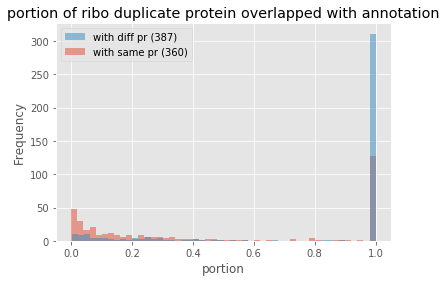

In [39]:
df = pd.DataFrame.from_dict(dup_same_rnas_overlap_pct,orient='index')
ax = df[0].plot(kind='hist',bins=50,alpha=0.5,label='with same pr (360)')
df = pd.DataFrame.from_dict(dup_diff_rnas_overlap_pct,orient='index')
ax = df[0].plot(kind='hist',bins=50,alpha=0.5,label='with diff pr (387)')
handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])
_ = ax.set_title('portion of ribo duplicate protein overlapped with annotation')
_ = ax.set_xlabel('portion')

|                 |          Summary                 |                             |
|-----------------|----------------------------------|-----------------------------|
| Unique (24733)  | same pr (13528)                  |                             |
|                 | new pr (1603)                    | filter coding isoform(1367) |
|                 | diff same frame (8708)           | Extend (480)                |
|                 |                                  | Shrink (8228)               |
|                 | diff diff frame (894)            | Overlap with anno (272)     |
|                 |                                  | UTR5 (446)                  |
|                 |                                  | UTR3 (176)                  |
| Duplicate(3974) | new pr (360)                     | Filter coding isoform (323) |
|                 |                                  | Overlap(56)                 |
|                 |                                  | Nonoverlap (304)            |
|                 | One is same with  anno pr (2151) | Overlap (360)               |
|                 |                                  | UTR5_3 (84)                 |
|                 |                                  | UTR5 (1135)                 |
|                 |                                  | UTR3 (572)                  |
|                 | Diff pr (1463)                   | Overlap(387)                |
|                 |                                  | UTR5_3 (41)                 |
|                 |                                  | UTR5 (609)                  |
|                 |                                  | UTR3 (426)                  |

#### Anazlye MS to Ribo protein sequence results

In [50]:
ms2ribo_new_fn = '/data/s3cha/CHO_ENOSI_JOB/taper/ribo_new.txt'
ms2ribo_new_df = pd.read_csv(ms2ribo_new_fn,sep='\t',header=0)

In [51]:
ms2ribo_new_df['rnaid'] = ms2ribo_new_df['Protein'].map(lambda x: x.split('_')[0])

In [53]:
ms2ribo_new_df['rna_pos']=ms2ribo_new_df['Protein'].map(lambda x: x.split(':')[0])

In [57]:
print 'riboseq identifies',ms2ribo_new_df['rnaid'].unique().shape[0],'more rnas than annotation'

riboseq identifies 1326 more rnas than annotation


In [44]:
import os,glob
from natsort import natsorted
path = '/media/lewislab/Dropbox (UCSD SBRG)/LewisPub/Data/RNAseq/2017_11_22_ext2_virus/CHO_Core_FDA_a-53602549/FASTQ_Generation_2017-11-18_05_44_16Z-62235322'
out_fn = '/data/shangzhong/list1.txt'
with open(out_fn,'w') as out:
    folders = [f for f in natsorted(glob.glob(path+'/*')) if os.path.isdir(f)]
    for folder in folders:
        fqFiles = glob.glob(folder+'/*.fastq.gz')
        idx = fqFiles[0].split('/')[-1].split('_')[0].split('-')[-1]
        name = fqFiles[0].split('/')[-1][:-9]
        full_path = '/'.join(folder.split('/')[5:])
        out.write('\t'.join([idx,name,full_path])+'\n')

In [59]:
new_splice = '/data/shangzhong/Proteogenomics/Database/splice_db.fa'
new_splice_index = SeqIO.index(new_splice,'fasta')

In [60]:
old_splice = '/data/s3cha/CHO_ENOSI_JOB/e22076b9e7ab40ef8fc2c63eddf67eba/sequence3/fasta3-00000.fa'
old_splice_index = SeqIO.index(old_splice,'fasta')

In [ ]:
path = '/data/s3cha/CHO_ENOSI_JOB/e22076b9e7ab40ef8fc2c63eddf67eba'
groups = range(9)
